In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('spotify.csv')

2024-02-06 11:07:38.522452: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 11:07:39.669492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 11:07:39.669719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 11:07:39.761349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 11:07:39.804253: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 11:07:41.792990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [5]:
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

In [6]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

In [7]:
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

In [8]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['danceability', 'energy', 'key', 'loudness',
                                  'mode', 'speechiness', 'acousticness',
                                  'instrumentalness', 'liveness', 'valence',
                                  'tempo', 'duration_ms']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['playlist_genre'])])

In [9]:
# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [10]:
X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Minimum Validation Loss: 0.1931


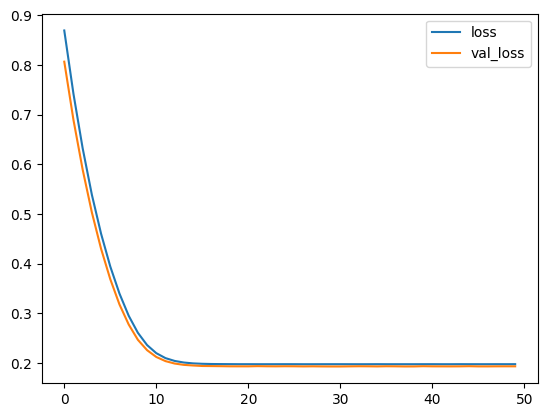

In [13]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Minimum Validation Loss: 0.1931


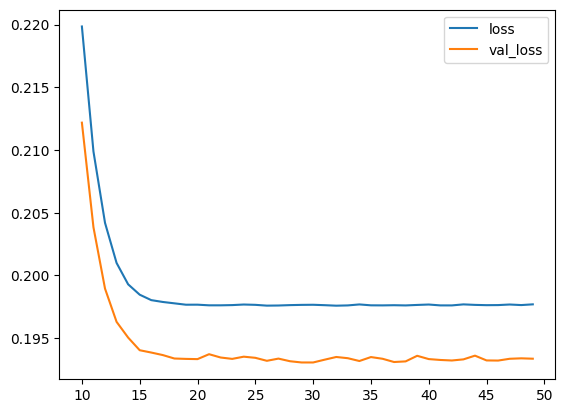

In [14]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Epoch 1/50
49/49 [==============================] - 1s 9ms/step - loss: 0.2193 - val_loss: 0.1997
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1980 - val_loss: 0.1961
Epoch 3/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1942 - val_loss: 0.1950
Epoch 4/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1917 - val_loss: 0.1972
Epoch 5/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1901 - val_loss: 0.1943
Epoch 6/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1886 - val_loss: 0.1942
Epoch 7/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1867 - val_loss: 0.1973
Epoch 8/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1862 - val_loss: 0.1945
Epoch 9/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1855 - val_loss: 0.1936
Epoch 10/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1849 - val_loss: 0.1955
Epoch 11/50
49/49 [

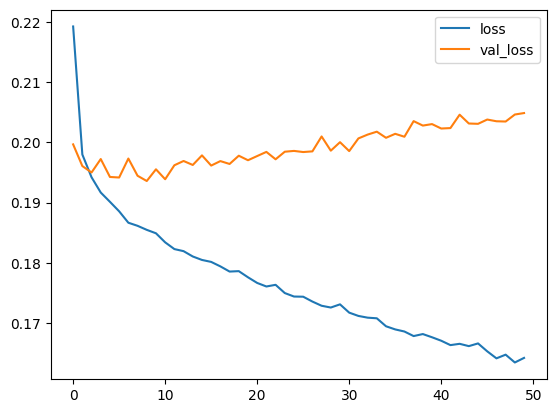

In [15]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [16]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Epoch 1/50
49/49 [==============================] - 1s 9ms/step - loss: 0.2501 - val_loss: 0.2059
Epoch 2/50
49/49 [==============================] - 0s 8ms/step - loss: 0.2036 - val_loss: 0.2029
Epoch 3/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1979 - val_loss: 0.1981
Epoch 4/50
49/49 [==============================] - 0s 7ms/step - loss: 0.1944 - val_loss: 0.1980
Epoch 5/50
49/49 [==============================] - 0s 8ms/step - loss: 0.1923 - val_loss: 0.1972
Epoch 6/50
49/49 [==============================] - 0s 9ms/step - loss: 0.1911 - val_loss: 0.1955
Epoch 7/50
49/49 [==============================] - 0s 9ms/step - loss: 0.1892 - val_loss: 0.1959
Epoch 8/50
49/49 [==============================] - 0s 8ms/step - loss: 0.1879 - val_loss: 0.1963
Epoch 9/50
49/49 [==============================] - 0s 9ms/step - loss: 0.1870 - val_loss: 0.1952
Epoch 10/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1864 - val_loss: 0.1976
Epoch 11/50
49/49 [

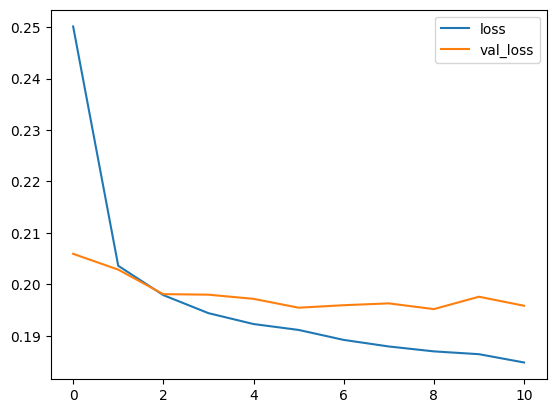

In [17]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))